### This script peform a first descriptive analysis of TB dataset, with particular focus on studying the quality of TB cases among vulnerable populations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau


# Read data

In [2]:
df = pd.read_csv('/Users/julianeoliveira/Documents/Projects/Bruno/Datalake/sinan_TB.csv', low_memory=False)

# Pre-processing the data

In [3]:
df = df.assign(NU_ANO = df.NU_ANO.astype(int),
               ones = 1,
               CS_SEXO = df.CS_SEXO.astype(str))
df = df[(df.NU_ANO >= 2001) & (df.NU_ANO < 2024)]

df = df[df.CS_SEXO != 'I']

df['CS_RACA'] = df['CS_RACA'].replace([np.inf, -np.inf], np.nan)
df['CS_RACA'] = df['CS_RACA'].fillna(9)
df['CS_RACA'] = df['CS_RACA'].replace([0, 6], 9)
df['CS_RACA'] = df['CS_RACA'].astype(int)

df['POP_LIBER'] = df['POP_LIBER'].replace([np.inf, -np.inf], np.nan) 
df['POP_LIBER'] = df['POP_LIBER'].replace([0, 9], np.nan)

df['POP_RUA'] = df['POP_RUA'].replace([np.inf, -np.inf], np.nan) 
df['POP_RUA'] = df['POP_RUA'].replace([0, 9], np.nan)

df['POP_SAUDE'] = df['POP_SAUDE'].replace([np.inf, -np.inf], np.nan) 
df['POP_SAUDE'] = df['POP_SAUDE'].replace([0, 3, 9], np.nan)

df['POP_IMIG'] = df['POP_IMIG'].replace([np.inf, -np.inf], np.nan) 
df['POP_IMIG'] = df['POP_IMIG'].replace([0, 3, 9], np.nan)

df['BENEF_GOV'] = df['BENEF_GOV'].replace([np.inf, -np.inf], np.nan) 
df['BENEF_GOV'] = df['BENEF_GOV'].replace([0, 3,4, 5, 6, 7, 8, 9], np.nan)

In [4]:
#### The following variables are null and we will exclude from the data

#DT_TRANSDM, DT_TRANSSM, DT_TRANSRM, DT_TRANSRS, DT_TRANSSE, CS_FLXRET,FLXRECEBI

cols_to_drop = [
    'DT_TRANSDM', 'DT_TRANSSM', 'DT_TRANSRM',
    'DT_TRANSRS', 'DT_TRANSSE', 'CS_FLXRET', 'FLXRECEBI'
]

# Drop the columns
df.drop(columns=cols_to_drop, inplace=True)

### 1. **General Overview**
- **Total number of TB cases** in the dataset.
- **Time series**: Number of cases per year/month (`DT_NOTIFIC`, `NU_ANO`).
- **Geographical distribution**:
  - By **region/state** (`SG_UF`, `ID_MUNICIP`, `ID_REGIONA`).
  - By **municipality of residence** (`ID_MN_RESI`), especially if you want to detect clusters or priority areas.


In [6]:
# Total number of TB cases in the dataset
len(df)

2086689

In [35]:
#(df.count()*100/len(df)).to_csv('/Users/julianeoliveira/Documents/github/Modelling_health_outcome_indigenous_pop/Data_outputs/count_of_non_null.csv')

In [7]:
# Number of cases per year
df.NU_ANO.value_counts()

2023    114147
2022    106523
2019     98981
2018     94672
2003     93826
2021     93611
2004     92972
2002     92005
2005     91415
2017     90357
2020     88241
2011     87619
2006     87323
2013     86839
2009     86705
2008     86437
2012     86119
2016     85794
2010     85403
2015     85320
2014     84999
2007     83821
2001     83560
Name: NU_ANO, dtype: int64

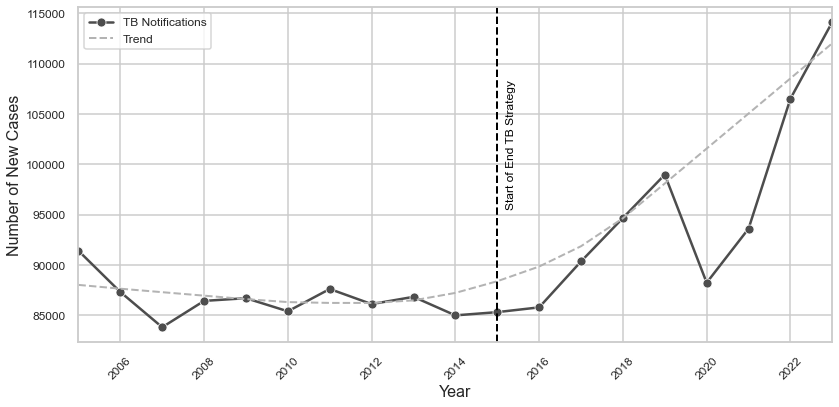

In [27]:
# Prepare data
data = df.NU_ANO.value_counts().reset_index()
data = data.rename(columns={'index': 'Year', 'NU_ANO': 'Notifications'}).sort_values("Year")
data = data.assign(Year = data.Year.astype(int))
data = data[data.Year >= 2005]

# Set ggplot-style aesthetics
sns.set_theme(style="whitegrid", context='talk')  # 'talk' makes fonts bigger (good for presentations)

# Plot
plt.figure(figsize=(12, 6))
#sns.lineplot(data=data, x="Year", y="Notifications", marker="o", label="TB Notifications", linewidth=2.5)
#sns.regplot(data=data, x="Year", y="Notifications", scatter=False, lowess=True, label="Trend", color='blue',line_kws={'linewidth': 1})

# Define custom colors
main_line_color = "#4D4D4D"   # Medium grey for main line
trend_line_color = "#B3B3B3"  # Light grey for trend line

# Plot lines
sns.lineplot(
    data=data, x="Year", y="Notifications", marker="o", 
    label="TB Notifications", linewidth=2.5, color=main_line_color
)

sns.regplot(
    data=data, x="Year", y="Notifications", scatter=False, lowess=True, 
    label="Trend", color=trend_line_color, line_kws={'linewidth': 2, 'linestyle': '--'}
)


# Add vertical line at 2015
plt.axvline(x=2015, color='black', linestyle='--', linewidth=2)
plt.text(2015 + 0.2, data["Notifications"].max() * 0.95, "Start of End TB Strategy", 
         rotation=90, verticalalignment='top', fontsize=12, color='black')


# Titles and labels
#plt.title("TB Notifications in Brazil by Year", fontsize=20, weight='bold')
plt.xlabel("Year", fontsize=16)
plt.ylabel("Number of New Cases", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("/Users/julianeoliveira/Documents/github/Modelling_health_outcome_indigenous_pop/Results/tb_notifications_brazil.pdf", format='pdf', bbox_inches='tight')
plt.show()



In [21]:
# Perform Kendall's tau test
tau, p_value = kendalltau(data["Year"], data["Notifications"])

# Output results
print(f"Kendall’s tau: {tau:.4f}")
print(f"P-value: {p_value:.4g}")


Kendall’s tau: 0.4152
P-value: 0.01282


In [18]:
#df.groupby(['CS_SEXO','NU_ANO'])['ones'].sum().reset_index()
df.CS_SEXO.value_counts()

M    1412831
F     673858
Name: CS_SEXO, dtype: int64

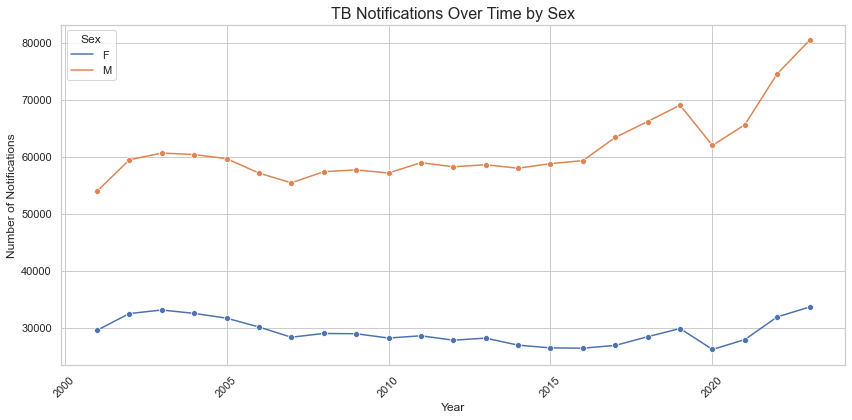

In [42]:
df_sex = df.groupby(['CS_SEXO','NU_ANO'])['ones'].sum().reset_index()

# Sort by year
df_sex = df_sex.sort_values("NU_ANO")

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sex, x="NU_ANO", y="ones", hue="CS_SEXO", marker="o")

plt.title("TB Notifications Over Time by Sex", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Number of Notifications")
plt.xticks(rotation=45)
plt.legend(title="Sex")
plt.tight_layout()
plt.show()


In [43]:
#1-Branca 2-Preta 3-Amarela 4-Parda 5-Indígena 9- Ignorad
df.CS_RACA.value_counts()

4    829757
1    577584
9    393989
2    248036
5     19992
3     17331
Name: CS_RACA, dtype: int64

In [44]:
df_raca = df.groupby(['NU_ANO','CS_RACA'])['ones'].sum().reset_index()

In [45]:
raca_labels = {
    1: 'Branca',
    2: 'Preta',
    3: 'Amarela',
    4: 'Parda',
    5: 'Indígena',
    9: 'Ignorado'
}

df_raca['CS_RACA'] = df_raca['CS_RACA'].map(raca_labels)


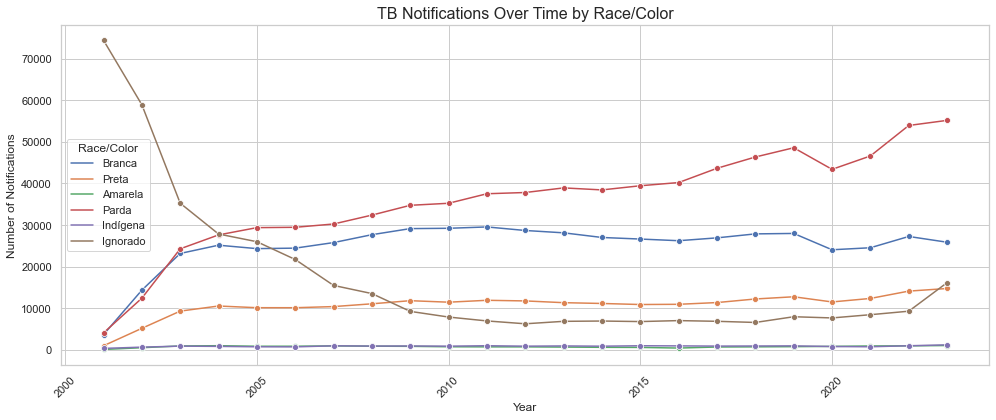

In [46]:
# Sort by year for correct line plotting
df_raca = df_raca.sort_values('NU_ANO')

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_raca, x='NU_ANO', y='ones', hue='CS_RACA', marker='o')

plt.title('TB Notifications Over Time by Race/Color', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Number of Notifications')
plt.legend(title='Race/Color')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [47]:
for value in df_raca.CS_RACA.unique():
    # Perform Kendall's tau test
    tau, p_value = kendalltau(df_raca[df_raca.CS_RACA == value]["NU_ANO"], df_raca[df_raca.CS_RACA == value]["ones"])

    # Output results
    print(value)
    print(f"Kendall’s tau: {tau:.4f}")
    print(f"P-value: {p_value:.4g}")

Branca
Kendall’s tau: 0.2253
P-value: 0.1404
Preta
Kendall’s tau: 0.6838
P-value: 6.587e-07
Amarela
Kendall’s tau: 0.0435
P-value: 0.794
Parda
Kendall’s tau: 0.9605
P-value: 6.044e-18
Indígena
Kendall’s tau: 0.3597
P-value: 0.01621
Ignorado
Kendall’s tau: -0.4466
P-value: 0.002413


In [48]:
# 1-Sim 2-Não 9-Ignorado
df.POP_LIBER.value_counts()

0.0    1111914
2.0     815021
1.0     103450
9.0      44040
Name: POP_LIBER, dtype: int64

In [49]:
df.POP_RUA.value_counts()

0.0    1113209
2.0     873728
9.0      47906
1.0      37924
Name: POP_RUA, dtype: int64

In [50]:
df.POP_SAUDE.value_counts()

0.0    1113406
2.0     800013
3.0      95814
9.0      51876
1.0      11420
Name: POP_SAUDE, dtype: int64

In [51]:
df.POP_IMIG.value_counts()

0.0    1137151
2.0     848714
9.0      58179
3.0      22229
1.0       5511
Name: POP_IMIG, dtype: int64

In [119]:
df.BENEF_GOV.value_counts()

0.0    1257889
2.0     472334
9.0     149105
1.0      54712
5.0          4
7.0          2
6.0          1
4.0          1
3.0          1
8.0          1
Name: BENEF_GOV, dtype: int64

In [ ]:




### 2. **Demographic Profile**
Analyze counts and proportions:
- **Age distribution** (`NU_IDADE_N`, `ANO_NASC`).
- **Sex distribution** (`CS_SEXO`).
- **Race/ethnicity** (`CS_RACA`), important for identifying Indigenous or other vulnerable populations.
- **Education level** (`CS_ESCOL_N`).
- **Pregnancy status** (`CS_GESTANT`), for women of reproductive age.
- **Special populations**:
  - Incarcerated (`POP_LIBER`)
  - Homeless (`POP_RUA`)
  - Health professionals (`POP_SAUDE`)
  - Immigrants (`POP_IMIG`)
  - Government assistance (`BENEF_GOV`)

> ✳️ *Tip: Cross-tabulate age group × sex × special population group for equity insights.*

### 3. **Clinical and Diagnostic Features**
- **Type of TB** (`FORMA`: pulmonary vs extrapulmonary).
- **Extrapulmonary details** (`EXTRAPU1_N`, `EXTRAPU2_N`, `EXTRAPUL_O`).
- **Diagnostic tests performed**:
  - Bacilloscopy (`BACILOSC_E`, `BACILOS_E2`, `BACILOSC_O`)
  - Culture (`CULTURA_ES`, `CULTURA_OU`)
  - Radiography (`RAIOX_TORA`)
  - Tuberculin test (`TESTE_TUBE`)
  - Molecular tests (`TEST_MOLEC`)
  - Histopathology (`HISTOPATOL`)
  - Sensitivity testing (`TEST_SENSI`)
- **HIV coinfection** (`HIV`)
- **Other comorbidities**: AIDS, alcoholism, diabetes, drug use, etc.

> ✳️ *Summarize how many cases had each type of diagnostic test and whether the result was positive.*

### 4. **Treatment Profile**
- **Initial treatment type** (`TRATAMENTO`).
- **Start date** of treatment (`DT_INIC_TR`) — useful for lag analysis between diagnosis and treatment.
- **Drug regimens** used (Rifampicin, Isoniazid, etc.).
- **Supervised treatment** (`TRAT_SUPER`, `TRATSUP_AT`).
- **Change in treatment** (`DT_MUDANCA`, `OUTRAS`, `OUTRAS_DES`).
- **Antiretroviral use** (`ANT_RETRO`), especially relevant in HIV+ cases.

### 5. **Outcome & Follow-Up**
- **Closure date of case** (`DT_ENCERRA`).
- **Situation at 9 and 12 months** (`SITUA_9_M`, `SITUA_12_M`).
- **Final outcome** (`SITUA_ENCE`): cured, treatment abandonment, death, etc.
- **Contact tracing data** (`NU_CONTATO`) — how many people were followed up?

> ✳️ *Good candidates for charts: Sankey diagrams showing treatment paths or bar charts of outcome proportions.*

### 6. **Temporal and Geographic Patterns**
- **Heat maps** of TB incidence by municipality or state.
- **Time series** of:
  - Case notifications by month.
  - Follow-up outcomes over time.
  - Treatment delays (diagnosis vs treatment start).

> ✳️ *You could stratify by urban vs remote/Indigenous areas to study disparities.*

### 7. **Data Quality and Completeness**
- % of **missing values** per variable.
- Consistency checks (e.g., `DT_NOTIFIC` before `DT_DIAG` or `DT_ENCERRA`).
- **Duplicated records** (`NDUPLIC_N`).
- Records that were **linked or transferred** (`IN_VINCULA`, `TRANSF`, etc.).

---

## 🔍 Bonus: Analysis Ideas for Modeling or Surveillance
- **Time-to-treatment**: How long between symptom onset, diagnosis, and treatment start?
- **Risk profiles**: Which comorbidities are most prevalent in poor outcomes?
- **Cluster detection**: Space-time analysis for outbreaks.
- **Data flow latency**: How long it takes for cases to reach SINAN (e.g., `DT_NOTIFIC` vs `DT_TRANSUS`).

---

Let me know if you're analyzing a subset (e.g., only Indigenous populations or specific years), and I can tailor this list further. I can also help with code snippets for summary tables or plots!

In [18]:
df.columns

Index(['TP_NOT', 'ID_AGRAVO', 'DT_NOTIFIC', 'NU_ANO', 'SG_UF_NOT',
       'ID_MUNICIP', 'ID_REGIONA', 'DT_DIAG', 'ANO_NASC', 'NU_IDADE_N',
       'CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'SG_UF', 'ID_MN_RESI',
       'ID_RG_RESI', 'ID_PAIS', 'NDUPLIC_N', 'IN_VINCULA', 'DT_DIGITA',
       'DT_TRANSUS', 'DT_TRANSDM', 'DT_TRANSSM', 'DT_TRANSRM', 'DT_TRANSRS',
       'DT_TRANSSE', 'CS_FLXRET', 'FLXRECEBI', 'MIGRADO_W', 'ID_OCUPA_N',
       'TRATAMENTO', 'INSTITUCIO', 'RAIOX_TORA', 'TESTE_TUBE', 'FORMA',
       'EXTRAPU1_N', 'EXTRAPU2_N', 'EXTRAPUL_O', 'AGRAVAIDS', 'AGRAVALCOO',
       'AGRAVDIABE', 'AGRAVDOENC', 'AGRAVOUTRA', 'AGRAVOUTDE', 'BACILOSC_E',
       'BACILOS_E2', 'BACILOSC_O', 'CULTURA_ES', 'CULTURA_OU', 'HIV',
       'HISTOPATOL', 'DT_INIC_TR', 'RIFAMPICIN', 'ISONIAZIDA', 'ETAMBUTOL',
       'ESTREPTOMI', 'PIRAZINAMI', 'ETIONAMIDA', 'OUTRAS', 'OUTRAS_DES',
       'TRAT_SUPER', 'NU_CONTATO', 'DOENCA_TRA', 'SG_UF_AT', 'ID_MUNIC_A',
       'DT_NOTI_AT', 'SG_UF_2', 'ID_MUN

In [14]:
df.TP_NOT.value_counts()

2    2091711
Name: TP_NOT, dtype: int64

In [16]:
df.ID_AGRAVO.value_counts()

A169    2091706
A16.          4
A144          1
Name: ID_AGRAVO, dtype: int64

In [ ]:
['DT_NOTIFIC', 'NU_ANO', 'SG_UF_NOT',
       'ID_MUNICIP', 'ID_REGIONA', 'DT_DIAG', 'ANO_NASC', 'NU_IDADE_N',
       'CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'SG_UF', 'ID_MN_RESI',
       'ID_RG_RESI', 'ID_PAIS', 'NDUPLIC_N', 'IN_VINCULA', 'DT_DIGITA',
       'DT_TRANSUS', 'DT_TRANSDM', 'DT_TRANSSM', 'DT_TRANSRM', 'DT_TRANSRS',
       'DT_TRANSSE', 'CS_FLXRET', 'FLXRECEBI', 'MIGRADO_W', 'ID_OCUPA_N',
       'TRATAMENTO', 'INSTITUCIO', 'RAIOX_TORA', 'TESTE_TUBE', 'FORMA',
       'EXTRAPU1_N', 'EXTRAPU2_N', 'EXTRAPUL_O', 'AGRAVAIDS', 'AGRAVALCOO',
       'AGRAVDIABE', 'AGRAVDOENC', 'AGRAVOUTRA', 'AGRAVOUTDE', 'BACILOSC_E',
       'BACILOS_E2', 'BACILOSC_O', 'CULTURA_ES', 'CULTURA_OU', 'HIV',
       'HISTOPATOL', 'DT_INIC_TR', 'RIFAMPICIN', 'ISONIAZIDA', 'ETAMBUTOL',
       'ESTREPTOMI', 'PIRAZINAMI', 'ETIONAMIDA', 'OUTRAS', 'OUTRAS_DES',
       'TRAT_SUPER', 'NU_CONTATO', 'DOENCA_TRA', 'SG_UF_AT', 'ID_MUNIC_A',
       'DT_NOTI_AT', 'SG_UF_2', 'ID_MUNIC_2', 'BACILOSC_1', 'BACILOSC_2',
       'BACILOSC_3', 'BACILOSC_4', 'BACILOSC_5', 'BACILOSC_6', 'TRATSUP_AT',
       'DT_MUDANCA', 'NU_COMU_EX', 'SITUA_9_M', 'SITUA_12_M', 'SITUA_ENCE',
       'DT_ENCERRA', 'TPUNINOT', 'POP_LIBER', 'POP_RUA', 'POP_SAUDE',
       'POP_IMIG', 'BENEF_GOV', 'AGRAVDROGA', 'AGRAVTABAC', 'TEST_MOLEC',
       'TEST_SENSI', 'ANT_RETRO', 'BAC_APOS_6', 'TRANSF', 'UF_TRANSF',
       'MUN_TRANSF']

In [17]:
df

,TP_NOT,ID_AGRAVO,DT_NOTIFIC,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,DT_DIAG,ANO_NASC,NU_IDADE_N,...,BENEF_GOV,AGRAVDROGA,AGRAVTABAC,TEST_MOLEC,TEST_SENSI,ANT_RETRO,BAC_APOS_6,TRANSF,UF_TRANSF,MUN_TRANSF
0,2,A169,2009-03-18,2009,12,120045.0,0.0,2009-03-18,1930,4079.0,...,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,2,A169,2009-10-19,2009,12,120034.0,0.0,2009-05-19,1972,4037.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,2,A169,2009-02-09,2009,12,120020.0,0.0,2009-02-06,1946,4062.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,2,A169,2009-06-23,2009,12,120025.0,0.0,2009-06-01,1969,4039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,2,A169,2009-08-21,2009,12,120040.0,0.0,2009-08-20,1968,4041.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091706,2,A169,2017-05-02,2017,35,355030.0,0.0,2008-07-21,1981,4035.0,...,0.0,2.0,2.0,5.0,7.0,0.0,0.0,0.0,NaN,NaN
2091707,2,A169,2014-04-01,2014,35,355030.0,0.0,2008-09-15,1976,4039.0,...,0.0,2.0,2.0,5.0,7.0,1.0,0.0,0.0,NaN,NaN
2091708,2,A169,2017-05-02,2017,35,355030.0,0.0,2008-07-21,1981,4035.0,...,0.0,2.0,2.0,5.0,7.0,0.0,0.0,0.0,NaN,NaN
2091709,2,A169,2014-04-01,2014,35,355030.0,0.0,2008-09-15,1976,4039.0,...,0.0,2.0,2.0,5.0,7.0,1.0,0.0,0.0,NaN,NaN


In [9]:
df['CS_RACA']

0          1.0
1          5.0
2          4.0
3          4.0
4          4.0
          ... 
2091706    2.0
2091707    1.0
2091708    2.0
2091709    1.0
2091710    4.0
Name: CS_RACA, Length: 2091711, dtype: float64